In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
import json
from sklearn.preprocessing import LabelEncoder

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.126.76.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.76.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [4]:
%cd gdrive/MyDrive/CSE4095\ -\ NLP/Delivery-4/

/content/gdrive/MyDrive/CSE4095 - NLP/Delivery-4


Read the processed (i.e., tokenized) dataset, labels, and splitted data (similar to Delivery 2)

In [5]:
dataset = {}
with open('data/dataset.json', encoding='utf-8') as fr:
    dataset = json.load(fr)

In [6]:
labels = {}
with open('data/labels.json', encoding='utf-8') as fr:
    labels = json.load(fr)

In [7]:
splitted_data = {}
with open('data/splitted_data.json', encoding='utf-8') as fr:
    splitted_data = json.load(fr)

Transform labels to integers

In [8]:
def encode_labels(labels):
    le = LabelEncoder()
    y = le.fit_transform(labels)
    return y

In [9]:
X_train, X_test, y_train, y_test = [], [], [], []

for key in ['train', 'test']:
    for i in range(len(splitted_data[f'X_{key}'])):
        exec(f"X_{key}.append(dataset[splitted_data['X_{key}'][i]])")
        exec(f"y_{key}.append(splitted_data['y_{key}'][i])")

In [10]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)

Create iterable Keras Dataset

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Print a sample instance along its label from the training dataset

In [12]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy().decode('utf-8'))
    print()
    print('labels: ', label.numpy())

texts:  taraflar arasındaki tazminat davasının yapılan yargılaması sonunda kararda yazılı nedenlerden dolayı davanın kısmen kabulüne dair verilen hükmün süresi içinde davalı vekili tarafından temyiz edilmesi üzerine dosya incelendi gereği düşünüldü davacı vekili davacıya iş yeri sigortası ile sigortalı iş yerinde meydana gelen hırsızlık sonucu çalınan emtia bedelinin sigortalısına ödendiğini ödenen bedelin rücu amacıyla başlatılan icra takibine davalı tarafça itiraz edildiğini yapılan incelemede davalı tarafça kurulan alarm sisteminin arızalı olduğunun ve olay saatinde de çalışmadığı anlaşıldığından davalının hırsızlık olayının meydana gelmesinde kusurunun bulunduğunu belirterek takibe yapılan itirazın iptali ile davalının icra inkar tazminatına mahkum edilmesini talep etmiştir davalı vekili sözleşme maddesi gereğince kendilerine rücu edilemeyeceğini belirterek davanın reddini savunmuştur mahkemece toplanan deliller ve benimsenen bilirkişi raporuna göre davanın reddine karar verilmiş d

Preprocess the datasets

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 512
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create an encoder layer for text vectorization

In [14]:
VOCAB_SIZE = 60724
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Create the model, compile, train and evaluate

In [15]:
type_ = 'lstm'
if type_ == 'lstm':
    lstm_layer = tf.keras.layers.LSTM(256)
else:
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        mask_zero=True),
    lstm_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                             decay_steps=10000,
                                                             decay_rate=0.9)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset)

Epoch 1/20
44/44 [==============================] - 845s 19s/step - loss: 1.7516 - accuracy: 0.4261 - val_loss: 1.1773 - val_accuracy: 0.6635
Epoch 2/20
44/44 [==============================] - 815s 19s/step - loss: 0.9105 - accuracy: 0.7180 - val_loss: 0.7012 - val_accuracy: 0.7736
Epoch 3/20
44/44 [==============================] - 839s 19s/step - loss: 0.6127 - accuracy: 0.8057 - val_loss: 0.5954 - val_accuracy: 0.8048
Epoch 4/20
44/44 [==============================] - 839s 19s/step - loss: 0.4653 - accuracy: 0.8492 - val_loss: 0.4843 - val_accuracy: 0.8416
Epoch 5/20
44/44 [==============================] - 760s 17s/step - loss: 0.3761 - accuracy: 0.8784 - val_loss: 0.4875 - val_accuracy: 0.8379
Epoch 6/20
44/44 [==============================] - 832s 19s/step - loss: 0.3300 - accuracy: 0.8925 - val_loss: 0.5245 - val_accuracy: 0.8267
Epoch 7/20
44/44 [==============================] - 828s 19s/step - loss: 0.3127 - accuracy: 0.8965 - val_loss: 0.4882 - val_accuracy: 0.8423
Epoch 

In [29]:
classes = ["Asliye Ceza Mahkemesi", "Asliye Hukuk Mahkemesi", "Ağır Ceza Mahkemesi", "Bölge Adliye Mahkemesi",
           "Ceza Dairesi", "EMPTY", "OTHER", "Ticaret Mahkemesi", "Çocuk Mahkemesi", "İş Mahkemesi"]

In [22]:
preds = model.predict(test_dataset)

In [24]:
y_pred = []
for arr in preds:
    y_pred.append(np.argmax(arr))

len(y_pred)

5569

In [25]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [26]:
cr = classification_report(y_test, y_pred, target_names=classes)
print(cr)

                        precision    recall  f1-score   support

 Asliye Ceza Mahkemesi       0.88      0.93      0.90      1998
Asliye Hukuk Mahkemesi       0.68      0.78      0.72       393
   Ağır Ceza Mahkemesi       0.69      0.65      0.67       380
Bölge Adliye Mahkemesi       0.94      0.90      0.92       487
          Ceza Dairesi       0.89      0.92      0.90       219
                 EMPTY       0.90      0.93      0.91      1325
                 OTHER       0.59      0.61      0.60       241
     Ticaret Mahkemesi       0.90      0.31      0.46        84
       Çocuk Mahkemesi       0.68      0.23      0.35       179
          İş Mahkemesi       0.94      0.87      0.90       263

              accuracy                           0.85      5569
             macro avg       0.81      0.71      0.73      5569
          weighted avg       0.85      0.85      0.84      5569



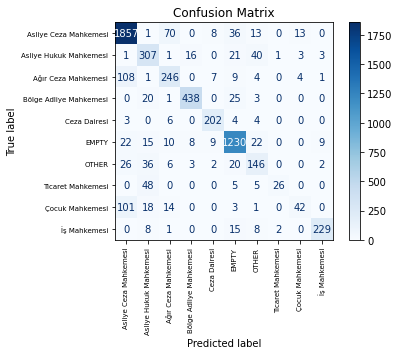

In [27]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title('Confusion Matrix')

plt.xticks(rotation = 90, fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('results/lstm_cm.png', dpi=300, bbox_inches='tight')